Inspired from https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/swin_unetr_brats21_segmentation_3d.ipynb

In [1]:
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import nrrd

from tqdm.auto import tqdm

In [2]:
import wandb

wandb.init(project="demo")

wandb: Currently logged in as: shyorn. Use `wandb login --relogin` to force relogin


In [2]:
import os

import json
from typing import Dict

from monai.transforms.transform import Transform, MapTransform
from monai.config import KeysCollection
from monai.utils.enums import TransformBackends

import torch

def generate_sample_paths_from_json(
    root_path : str
):
    config_path = os.path.join(
        root_path,
        "data.json"
    )
    with open(config_path, "r") as file:
        config : Dict = json.load(file)
    
    sample_paths = []
    for sample_id, sample_content in config.items():
        mri_path = os.path.join(
            root_path,
            sample_id,
            sample_content["image"]
        )
        label_path = os.path.join(
            root_path,
            sample_id,
            sample_content["label"]
        )
        sample_paths.append({
            "image" : mri_path,
            "label" : label_path
        })
    
    return sample_paths

class ConvertToMultiChannelBasedOnBtsClasses (Transform):
    """
    Converts 3 dimensional label to 4 dimensional based on the Brain Tumor
    Classification (BTS) dataset
    label 1 is the brain (gray matter)
    label 2 is the tumour
    """
    backend = [TransformBackends.TORCH]

    def __call__ (self, img : torch.Tensor):
        result = [img == 1, img == 2]
        
        return torch.stack(result, dim=0)


class ConvertToMultiChannelBasedOnBtsClassesd (MapTransform):
    """
    Dictionary based wrapper of ConvertToMultiChannelBasedOnBtsClasses
    Converts 3 dimensional label to 4 dimensional based on the Brain Tumor
    Classification (BTS) dataset
    label 1 is the brain (gray matter)
    label 2 is the tumour
    """

    backend = ConvertToMultiChannelBasedOnBtsClasses.backend

    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.converter = ConvertToMultiChannelBasedOnBtsClasses()
    
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.key_iterator(data_dict):
            data_dict[key] = self.converter(data_dict[key])
        
        return data_dict

In [3]:
root_path = "../../data"

In [4]:
batch_size = 2
shuffle = True

roi = (128, 128, 128)

In [71]:
from monai import data
from monai import transforms
from monai.data.utils import list_data_collate

import torchvision

# get paths by using the json file
sample_paths = generate_sample_paths_from_json(root_path)


def add_new_axis(data):
    data["image"] = data["image"][None, ...]
    data["label"] = data["label"][None, ...]
    return data
    
"""
    transforms.CropForegroundd(
        keys=["image", "label"],
        source_key="image",
        k_divisible=[roi[0], roi[1], roi[2]],
    ),
    transforms.RandSpatialCropd(
        keys=["image", "label"],
        roi_size=[roi[0], roi[1], roi[2]],
        random_size=False,
    ),
    transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
    transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
"""
    
# create transformations
img_transforms = transforms.Compose([
    transforms.LoadImaged(keys=["image", "label"], image_only=True),
    add_new_axis,
    transforms.Resized(keys=["image", "label"], spatial_size=(200, 200, 200)),
    ConvertToMultiChannelBasedOnBtsClassesd(keys=["label"]),
    
    ]
)

dataset = data.Dataset(
    data=sample_paths,
    transform=img_transforms,
)

def collate_fn(batch):
    print(len(batch))
    for data in batch:
        for (key, value) in data.items():
            print(key, value.shape, value.dtype)
        print()
    return None

dataloader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [72]:
x = next(iter(dataloader))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f45b2a321f0>
Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f45b2a321f0>
Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-p

2
image torch.Size([1, 200, 200, 200]) torch.float32
label torch.Size([2, 1, 200, 200, 200]) torch.bool

image torch.Size([1, 200, 200, 200]) torch.float32
label torch.Size([2, 1, 200, 200, 200]) torch.bool

2
image torch.Size([1, 200, 200, 200]) torch.float32
label torch.Size([2, 1, 200, 200, 200]) torch.bool

image torch.Size([1, 200, 200, 200]) torch.float32
label torch.Size([2, 1, 200, 200, 200]) torch.bool

2
image torch.Size([1, 200, 200, 200]) torch.float32
label torch.Size([2, 1, 200, 200, 200]) torch.bool

image torch.Size([1, 200, 200, 200]) torch.float32
label torch.Size([2, 1, 200, 200, 200]) torch.bool



In [70]:
x = next(iter(dataloader))

2023-02-23 06:46:36,449 - > collate dict key "image" out of 2 keys
2023-02-23 06:46:36,461 - >> collate/stack a list of tensors
2023-02-23 06:46:36,488 - > collate dict key "label" out of 2 keys
2023-02-23 06:46:36,503 - >> collate/stack a list of tensors


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/monai/data/utils.py", line 468, in list_data_collate
    ret[key] = collate_meta_tensor(data_for_batch)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/monai/data/utils.py", line 434, in collate_meta_tensor
    collated.meta = default_collate([i.meta or TraceKeys.NONE for i in batch])
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 128, in collate
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 128, in <dictcomp>
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 139, in collate
    raise RuntimeError('each element in list of batch should be of equal size')
RuntimeError: each element in list of batch should be of equal size

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/monai/data/utils.py", line 483, in list_data_collate
    raise RuntimeError(re_str) from re
RuntimeError: each element in list of batch should be of equal size
Collate error on the key 'label' of dictionary data.

MONAI hint: if your transforms intentionally create images of different shapes, creating your `DataLoader` with `collate_fn=pad_list_data_collate` might solve this problem (check its documentation).


2023-02-23 06:46:38,723 - > collate dict key "image" out of 2 keys
2023-02-23 06:46:38,736 - >> collate/stack a list of tensors
2023-02-23 06:46:38,762 - > collate dict key "label" out of 2 keys
2023-02-23 06:46:38,779 - >> collate/stack a list of tensors


In [18]:
for label_dir in os.listdir(root_path):
    if label_dir.endswith(".json"):
        continue
    label_dir = os.path.join(root_path, label_dir)
    files = os.listdir(label_dir)
    label_path = os.path.join(label_dir, "transformed_label.nrrd")
    data_path = None
    for file in files:
        if "t1" in file.lower():
            data_path = os.path.join(label_dir, file)
    if not data_path:
        print(label_dir)
        continue
    
    

../../data/zeynep_altınisik_label
../../data/ahmet_timur_label/transformed_label.nrrd ../../data/ahmet_timur_label/21 t1_mprage_tra_p2_iso.nrrd
../../data/enver_akkaya_label/transformed_label.nrrd ../../data/enver_akkaya_label/13 t1_mprage_tra_p2_iso.nrrd
../../data/altun_nurten_label/transformed_label.nrrd ../../data/altun_nurten_label/17 t1_mprage_tra_p2_iso.nrrd
../../data/munevver_altan_label/transformed_label.nrrd ../../data/munevver_altan_label/22 t1_mprage_tra_p2_iso.nrrd
../../data/osman_altintas/transformed_label.nrrd ../../data/osman_altintas/17 t1_mprage_tra_p2_iso.nrrd
../../data/cansel_akgun_label/transformed_label.nrrd ../../data/cansel_akgun_label/40009 ORIG 3D Ax T1 MP-RAGE.nrrd
../../data/ramazan_acer_label/transformed_label.nrrd ../../data/ramazan_acer_label/7 t1_mprage_tra_p2_iso.nrrd
../../data/salih_adali_label/transformed_label.nrrd ../../data/salih_adali_label/17 t1_mprage_tra_p2_iso.nrrd
../../data/elif_ece_altun_label


### Check data shape and visualize

image shape: (232, 256, 176), label shape: (232, 256, 176)


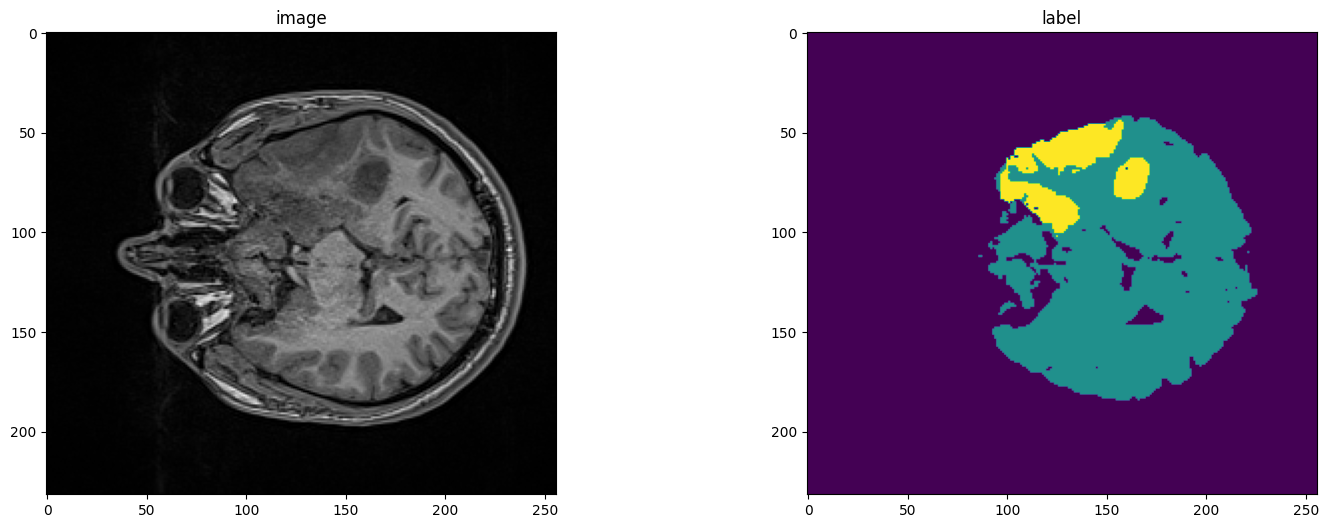

In [56]:
img, _ = nrrd.read(f"{root_path}/ahmet_timur_label/21 t1_mprage_tra_p2_iso.nrrd")
label, _ = nrrd.read(f"{root_path}/ahmet_timur_label/transformed_label.nrrd")
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

0.4281575679779053
0.4110989570617676
image shape: torch.Size([1, 200, 200, 200]), label shape: torch.Size([1, 200, 200, 200])


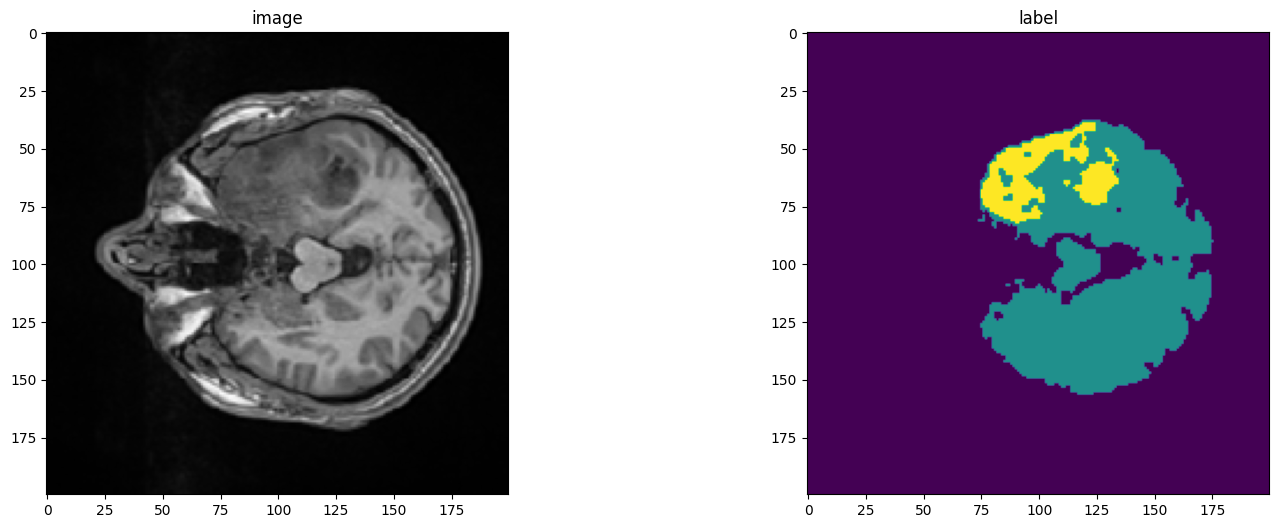

In [42]:
img, _ = nrrd.read(f"{root_path}/ahmet_timur_label/21 t1_mprage_tra_p2_iso.nrrd")
start = time.time()
img = transforms.Resize(spatial_size=(200, 200, 200))(img[None, ...])
print(time.time() - start)

start = time.time()
label, _ = nrrd.read(f"{root_path}/ahmet_timur_label/transformed_label.nrrd")
label = transforms.Resize(spatial_size=(200, 200, 200))(label[None, ...])
print(time.time() - start)

print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 78])
plt.show()

In [35]:
label.shape

torch.Size([1, 200, 200, 200])

In [21]:
img.shape

torch.Size([232, 200, 200, 200])

In [11]:
import torch

from monai.networks.nets import SwinUNETR
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.transforms import (
    AsDiscrete,
    Activations,
)
from monai.inferers import sliding_window_inference

from monai.utils.enums import MetricReduction
from monai.data import decollate_batch
from functools import partial

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


### Setup data directory

In [12]:
import os
import tempfile

directory = os.environ.get("MONAI_DATA_DIRECTORY")
directory = "/home/vedatb/senior-project/bbm47980_bts/notebooks/swinunetr-checkpoints"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/vedatb/senior-project/bbm47980_bts/notebooks/swinunetr-checkpoints


Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


### Setup average meter, fold reader, checkpoint save

In [13]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

In [14]:
def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

### Setup device

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
device

device(type='cuda')

### SwinUNETR Model

In [16]:
model = SwinUNETR(
    img_size=roi,
    in_channels=1, # t1 images,
    out_channels=2, # brain and tumor
    feature_size=48,
    use_checkpoint=True,
)

model = model.to(device)

### Optimizer and Loss Function

In [17]:
batch_size = 2
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 10

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [18]:
# Causes cuDNN to benchmark multiple convolution algorithms and select the fastest.
torch.backends.cudnn.benchmark = True

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [19]:
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [20]:
model_inferer = partial(
    sliding_window_inference,
    roi_size=roi,
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

### Define Train and Validation Epoch

In [21]:
def train_epoch(
    model,
    loader,
    optimizer,
    epoch,
    loss_function,
):
    model.train()
    run_loss = AverageMeter()
    start_time = time.time()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_function(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "Loss: {:.4f}".format(run_loss.avg),
            "Time {:.2f}s".format(time.time() - start_time),
        )
        wandb.log({"loss": run_loss})
        start_time = time.time()
    return run_loss.avg

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [22]:
def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    run_acc = AverageMeter()
    
    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [
                post_pred(post_sigmoid(val_pred_tensor))
                for val_pred_tensor in val_outputs_list
            ]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_brain = run_acc.avg[0]
            dice_tumor = run_acc.avg[1]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_brain:",
                dice_brain,
                ", dice_tumor:",
                dice_tumor,
            )
            wandb.log({"dice_brain": dice_brain, "dice_tumor": dice_tumor})
            
    return run_acc.avg

In [23]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_brain = []
    dices_tumor = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_function=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "Loss: {:.4f}".format(train_loss),
            "Time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_brain = val_acc[0]
            dice_tumor = val_acc[1]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_brain:",
                dice_brain,
                ", dice_tumor:",
                dice_tumor,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_brain.append(dice_brain)
            dices_tumor.append(dice_tumor)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_brain,
        dices_tumor,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

In [24]:
start_epoch = 0

(val_acc_max, dices_brain, dices_tumor, dices_avg, loss_epochs, trains_epoch,) = trainer(
    model=model,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Thu Feb 23 05:08:28 2023 Epoch: 0
2023-02-23 05:08:35,131 - > collate dict key "image" out of 6 keys
2023-02-23 05:08:35,143 - >> collate/stack a list of tensors
2023-02-23 05:08:35,151 - > collate dict key "label" out of 6 keys
2023-02-23 05:08:35,168 - >> collate/stack a list of tensors
2023-02-23 05:08:35,173 - > collate dict key "image_meta_dict" out of 6 keys
2023-02-23 05:08:35,179 - >> collate dict key "type" out of 11 keys
2023-02-23 05:08:35,181 - >> collate dict key "dimension" out of 11 keys
2023-02-23 05:08:35,183 - >> collate dict key "space" out of 11 keys
2023-02-23 05:08:35,184 - >> collate dict key "kinds" out of 11 keys
2023-02-23 05:08:35,187 - >>> collate list of sizes: [3, 3, 3, 3].
2023-02-23 05:08:35,189 - >> collate dict key "endian" out of 11 keys
2023-02-23 05:08:35,191 - >> collate dict key "encoding" out of 11 keys
2023-02-23 05:08:35,192 - >> collate dict key "original_affine" out of 11 keys
2023-02-23 05:08:35,196 - >>> collate/stack a list of numpy arrays

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/monai/data/utils.py", line 468, in list_data_collate
    ret[key] = collate_meta_tensor(data_for_batch)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/monai/data/utils.py", line 434, in collate_meta_tensor
    collated.meta = default_collate([i.meta or TraceKeys.NONE for i in batch])
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 128, in collate
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 128, in <dictcomp>
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 139, in collate
    raise RuntimeError('each element in list of batch should be of equal size')
RuntimeError: each element in list of batch should be of equal size

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "/home/vedatb/miniconda3/envs/ldm/lib/python3.8/site-packages/monai/data/utils.py", line 483, in list_data_collate
    raise RuntimeError(re_str) from re
RuntimeError: each element in list of batch should be of equal size
Collate error on the key 'label' of dictionary data.

MONAI hint: if your transforms intentionally create images of different shapes, creating your `DataLoader` with `collate_fn=pad_list_data_collate` might solve this problem (check its documentation).


In [ ]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

In [ ]:
plt.figure("train", (12, 6))

plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()

## Plot the Losses and Metrics

In [ ]:
plt.figure("train", (18, 6))

plt.subplot(1, 3, 1)
plt.title("Val Mean Dice Brain")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_brain, color="blue")

plt.subplot(1, 3, 2)
plt.title("Val Mean Dice Tumor")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tumor, color="brown")

plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tumor, color="purple")
plt.show()

## Test the Model

### Read test json

In [ ]:
test_json_path = root_path
test_paths = generate_sample_paths_from_json(test_json_path)

### Create test dataset and dataloader

In [ ]:
test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        add_new_axis,
        ConvertToMultiChannelBasedOnBtsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_paths, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

### Load the best saved checkpoint and perform inference
We select a single case from the validation set and perform inference to compare the model segmentation output with the corresponding label

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[0] == 1] = 1
        seg_out[seg[1] == 1] = 2



In [ ]:
slice_num = 67
img, _ = nrrd.read(f"{root_path}/ahmet_timur_label/21 t1_mprage_tra_p2_iso.nrrd")
label, _ = nrrd.read(f"{root_path}/ahmet_timur_label/transformed_label.nrrd")
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

In [ ]:
slice_num = 175
img, _ = nrrd.read(f"{root_path}/ahmet_timur_label/21 t1_mprage_tra_p2_iso.nrrd")
label, _ = nrrd.read(f"{root_path}/ahmet_timur_label/transformed_label.nrrd")
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
a = plt.show()

In [ ]:
num_slice = img.shape[2]

for slice_num in range(num_slice):
    wandb.log({
        "Image": wandb.Image(img[:, :, slice_num]),
        "Label": wandb.Image(label[:, :, slice_num]),
        "Prediction": wandb.Image(seg_out[:, :, slice_num])
    })